03 - Detections Database and API
=======

This notebook demonstrates how to access the HDF5 container for the HETDEX line detections database through the API. Querying of the database through an interactive GUI follows in Notebook 11 - Querying Detections GUI. This database is a catalog of line emission detections and their associated 1D, aperture summed, psf-weighted spectra. There are three tables contained within this HDF5 file: 

1. Detections - this is the main database of line detection sources. It provides the position and central wavelength of each detection and corresponding line fluxes. A source detection corresponds to an emission line so it is possible to have multiple line detections at different wavelengths for a single source. There can also be multiple observations of the same line if it has been observed in multiple shots or if it is associated with a large source. 

2. Fibers - for each source detection, this table lists information about each fiber used to extract the flux measurment and weighted spectrum. This allows a user to return to the processed data products (ie. the shot HDF5 files) to investigate the source further.

3. Spectra - for each source, this table contains arrays of wavelength and 1D flux-weighted aperture summed spectral data and corresponding errors. Non-calibrated spectra is also provided in counts


In [1]:
%matplotlib inline
import sys
import os
import os.path
import subprocess
import numpy as np
import tables as tb
import matplotlib.pyplot as plt
import pickle

from astropy.io import ascii
from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
import astropy.units as u

from hetdex_api import config
from hetdex_api.detections import Detections

### Initiate the API

When you call `Detections()` you intiate the Detections Class object which takes columns from the Detections Table in the HDF5 file and adds them as array attributes to the Detections class object. If you append the call with `refine()` then a number of downselections are applied to the database to return a more robust list of line emitters. `refine()` removes spurious detections found in bad amps or at the edges of the CCD. It also removes all objects with gband mag < 17. This mostly removes stars, but a few bright galaxies and even bright OII emitters are removed.

In [2]:
detects = Detections('hdr1').refine()
## or if you want to open the continuum source catalog:
## detects = Detections('cont_sources')

Here are a list of attributes built into the Detections class:

In [3]:
detects.__dict__.keys()

['linewidth_err',
 'sn',
 'sn_err',
 'z_prelim',
 'chi2_err',
 'date',
 'mag_match',
 'obsid',
 'shotid',
 'linewidth',
 'fwhm',
 'plae_poii_cat',
 'dec_match',
 'ifuslot',
 'n_ifu',
 'aperture_filter',
 'flux_err',
 'filename',
 'plae_poii_hetdex',
 'inputid',
 'ra_match',
 'coords',
 'flux_limit',
 'detectid',
 'ra',
 'detectid_elix',
 'dist_match',
 'chi2',
 'vis_class',
 'aperture_mag',
 'wave_err',
 'ifuid',
 'detectname',
 'wave',
 'gmag',
 'amp',
 'cat_filter',
 'x_raw',
 'hdfile',
 'specid',
 'continuum',
 'hdfile_elix',
 'multiframe',
 'plae_poii_aperture',
 'y_raw',
 'throughput',
 'continuum_err',
 'flux',
 'field',
 'fibnum',
 'dec']

Most of these columns come directly from the Detections table in the detect_hdr1.h5 file. You can find information for each column in the HETDEX DR1 Document (/work/03946/hetdex/hdr1/doc/Hetdex_Data_Release_1.pdf). Some values including field (survey.field), fwhm (guider seeing/survey.fwhm_moffat), throughput (survey.response_4540), flux_limit (survey.fluxlimit_4550), n_ifu (survey.n_ifu) are copied in from the Survey HDF5 file for additional analysis.  We also attach probabilities for a source to be an LAE compared to an OII emitter (plae_poii) calculated by ELiXer using the VIRUS continuum ('plae_poii_hetdex'), a matched catalog magnitude ('plae_poii_cat'), or from a magnitude measured from associated optical imaging ('plae_poii_aperture').

# Querying by sky coordinates

Upon initialization of the Detections Class, sky coordinates are converted to an Astropy sky coordinates array to allow for easy querying:

In [4]:
detects.coords

<SkyCoord (ICRS): (ra, dec) in deg
    [(149.77184,  1.948503), (149.78958,  1.900873),
     (149.84552,  1.935277), ..., (189.64575, 50.83938 ),
     (170.32608, 51.549652), (170.32336, 51.58739 )]>

To query a region of the sky, you can use the Detections function `query_by_coords` which takes an astropy coords objects as an argument as well as a radius represented by an astropy quantity. It returns a boolean mask to index the Detections class object.

In [8]:
obj_coords = SkyCoord(199.35704 * u.deg, 51.06718 * u.deg, frame='icrs')

In [9]:
maskregion = detects.query_by_coords(obj_coords, 10. * u.arcsec)

The Detections class allows slicing so that a boolean mask applied to the class will slice each array attribute accordingly:

In [10]:
detects_in_region = detects[maskregion]
print(np.size(detects_in_region.detectid))

12


For this example, we have found 12 detections in this region, we can examine these via the ELiXer reports using `elixer_widgets.py`. To do so we need to save the detectid list to examine in the widget. We save it using the `pickle` module (be sure to ! pip install --user pickle if you have not already). This preserves the numpy data array format and stores the data in a compressed binary format.

In [11]:
outfile = open('detects_obj.pickle', 'wb')
pickle.dump(detects_in_region.detectid, outfile)
outfile.close()

You can the run the elixer_widget to scan through the ELiXer reports for this object. Use the "Next DetectID" button to scan the list. The "DetectID" text widget will give access to all reports interactively and scans in increasing single digit increments, but the green Next DetectID button will go in order of the ingest list from 'detects_obj.pickle'.

In [12]:
%run /work/05350/ecooper/stampede2/HETDEX_API/hetdex_api/elixer_widgets.py 'detects_obj.pickle'

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEJvdW5kZWRJbnRUZXh0KHZhbHVlPTEwMDAyMDg3NTYsIGRlc2NyaXB0aW9uPXUnRGV0ZWN0SUQ6JywgbWF4PTEwMDAyMDg5MTAsIG1pbj0xMDAwMjA4NzXigKY=


For more information on using the Elixer Widgets GUI go to Notebook 12. We will discuss team classification efforts there. But for quick investigation its helpful to pull the GUI up to just scan through a detection list.

## Accessing 1D Spectra

Spectra in counts and flux-calibrated units are stored in the Spectra Table of the Detection HDF5 file, it can be accessed directly through the Detections class object which stores the detect HDF5 as an attribute:

In [13]:
print(detects.hdfile)

/work/03946/hetdex/hdr1/detect/detect_hdr1.h5 (File) 'HDR1 Detections Database'
Last modif.: 'Mon Apr  1 12:39:46 2019'
Object Tree: 
/ (RootGroup) 'HDR1 Detections Database'
/Detections (Table(690868,)) 'HETDEX Line Detection Catalog'
/Fibers (Table(9397618,)) 'Fiber info for each detection'
/Spectra (Table(690797,)) '1D Spectra for each Line Detection'



In [14]:
spectra = detects.hdfile.root.Spectra

This is a very large table so its not advised to read it in all at once. The columns are:

In [15]:
spectra.cols

/Spectra.cols (Cols), 8 columns
  detectid (Column(690797,), int64)
  wave1d (Column(690797, 1036), ('<f4', (1036,)))
  spec1d (Column(690797, 1036), ('<f4', (1036,)))
  spec1d_err (Column(690797, 1036), ('<f4', (1036,)))
  counts1d (Column(690797, 1036), ('<f4', (1036,)))
  counts1d_err (Column(690797, 1036), ('<f4', (1036,)))
  apsum_counts (Column(690797, 1036), ('<f4', (1036,)))
  apsum_counts_err (Column(690797, 1036), ('<f4', (1036,)))

Flux calibrated, psf-weighted 1D spectra can be retrieved via the API for a single detectid through the function `get_spectrum`:

In [16]:
detectid_nice_lae = 1000208773
spec_table = detects.get_spectrum(detectid_nice_lae) 

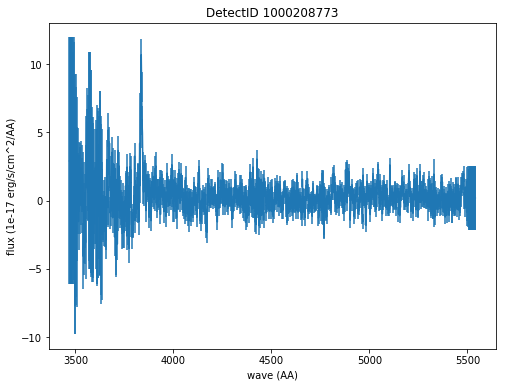

In [17]:
detects.plot_spectrum(detectid_nice_lae)

or if we want to zoom in on the emission line:

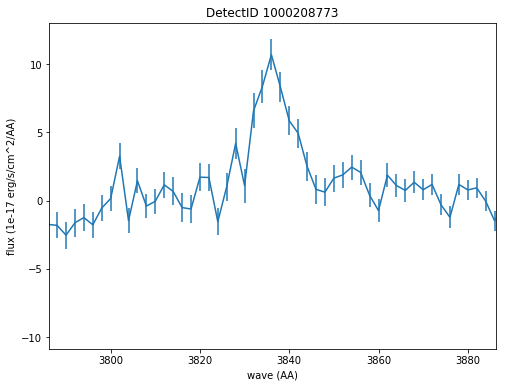

In [18]:
cw = detects.wave[detects.detectid == detectid_nice_lae]
detects.plot_spectrum(detectid_nice_lae, xlim=(cw-50, cw+50))

You can also save the spectrum to a text file. It is automatically saved as spec_##detectid##.dat, but you can also use the argument `outfile`

In [19]:
detects.save_spectrum(detectid_nice_lae)
# or
# detects.save_spectrum(detectid_nice_lae, outfile='tmp.txt')

## Example: Finding average number of sources per IFU 

To reach our survey goal we need to obtain a critical number of detections per IFU on average. Here we show how the number of detections based on the signal-to-noise requirement. 

In [34]:
ndets_ifu = []

sn_array = np.arange(start = 5, stop = 10, step = 1)

# only choose detections that lied on good shots

for sn_i in sn_array:
    sel = (detects.sn > sn_i) * (detects.n_ifu > 0) * (detects.chi2 < 3) * (detects.chi2 >0.1)
    detifu = 1./(detects.n_ifu[sel])
    ndets_ifu.append(np.sum(detifu)/np.size(np.unique(detects.shotid)))
    
ndets_ifult2 = []

for sn_i in sn_array:
    sel = (detects.sn > sn_i) * (detects.n_ifu > 0) * (detects.chi2 < 2) * (detects.chi2 >0.1)
    detifu = 1./(detects.n_ifu[sel])
    ndets_ifult2.append(np.sum(detifu)/np.size(np.unique(detects.shotid)))
    
# only choose detections that lied on good shots
sel = (detects.throughput > 0.08) * (detects.fwhm < 2.5)
detects_good_shots = detects[sel]

ndets_ifu_gs =[]
for sn_i in sn_array:
    sel = (detects_good_shots.sn > sn_i) * (detects_good_shots.n_ifu > 0) * (detects_good_shots.chi2 < 3) * (detects_good_shots.chi2 >0.1)
    detifu = 1./(detects_good_shots.n_ifu[sel])
    ndets_ifu_gs.append(np.sum(detifu)/np.size(np.unique(detects_good_shots.shotid)))
    
ndets_ifu_gs_lt2 = []
for sn_i in sn_array:
    sel = (detects_good_shots.sn > sn_i) * (detects_good_shots.n_ifu > 0) * (detects_good_shots.chi2 < 2) * (detects_good_shots.chi2 >0.1)
    detifu = 1./(detects_good_shots.n_ifu[sel])
    ndets_ifu_gs_lt2.append(np.sum(detifu)/np.size(np.unique(detects_good_shots.shotid)))
    

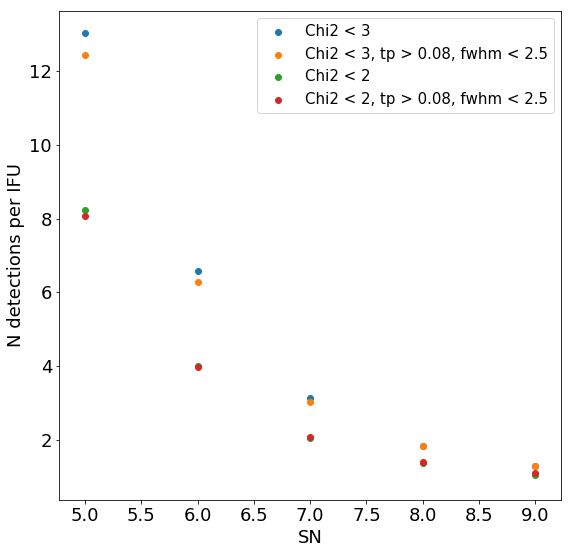

In [42]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(9,9))
plt.scatter(sn_array, ndets_ifu, label='Chi2 < 3')
plt.scatter(sn_array, ndets_ifu_gs, label='Chi2 < 3, tp > 0.08, fwhm < 2.5')
plt.scatter(sn_array, ndets_ifult2, label='Chi2 < 2')
plt.scatter(sn_array, ndets_ifu_gs_lt2, label='Chi2 < 2, tp > 0.08, fwhm < 2.5')
plt.xlabel('SN')
plt.ylabel('N detections per IFU')
plt.legend(fontsize='small')
plt.savefig('ndetsperifu_vs_sn.png')

If you want to just save a subset of columns for a subset of detections, here's an example you to work with:

In [20]:
table = Table([detects.detectid, detects.ra, detects.dec, detects.wave, detects.sn, detects.chi2, detects.shotid, detects.n_ifu, detects.fwhm, detects.throughput])

In [21]:
ascii.write(table, 'detects_apr25.tab', names=['detectid', 'ra', 'dec', 'wave', 'sn', 'chi2','shotid','n_ifu','fwhm','throughput'])

## Getting Fiber information for a detection

You can find a list of all fibers used in the measurement in the Fibers table. The Fibers table and its associated columns can be accessed similar to the Spectra table by searching for a match in the the detectid column. 

In [15]:
fibers = detects.hdfile.root.Fibers
fibers.cols

/Fibers.cols (Cols), 20 columns
  detectid (Column(9397618,), int64)
  ra (Column(9397618,), float32)
  dec (Column(9397618,), float32)
  multiframe (Column(9397618,), |S20)
  fibnum (Column(9397618,), int32)
  x_ifu (Column(9397618,), float32)
  y_ifu (Column(9397618,), float32)
  date (Column(9397618,), int32)
  obsid (Column(9397618,), int32)
  expnum (Column(9397618,), int32)
  distance (Column(9397618,), float32)
  timestamp (Column(9397618,), |S17)
  wavein (Column(9397618,), float32)
  flag (Column(9397618,), int32)
  weight (Column(9397618,), float32)
  ADC (Column(9397618, 5), ('<f4', (5,)))
  amp (Column(9397618,), |S2)
  ifuid (Column(9397618,), |S3)
  ifuslot (Column(9397618,), |S3)
  specid (Column(9397618,), |S3)

Access the fiber table for the above source:

In [16]:
fiber_table = fibers.read_where("detectid == detectid_nice_lae") 

In [24]:
Table(fiber_table)

detectid,ra,dec,multiframe,fibnum,x_ifu,y_ifu,date,obsid,expnum,distance,timestamp,wavein,flag,weight,ADC [5],amp,ifuid,ifuslot,specid
int64,float32,float32,str20,int32,float32,float32,int32,int32,int32,float32,str17,float32,int32,float32,float32,str2,str3,str3,str3
1000208773,199.35771,51.066715,multi_025_076_032_RU,12,-5.08,24.24,20180313,11,1,2.26213,20180313T060419.0,3836.2,0,7.26,0.844 .. 1.002,RU,032,076,025
1000208773,199.35664,51.066483,multi_025_076_032_RU,13,-7.63,24.24,20180313,11,1,2.66042,20180313T060419.0,3836.2,0,3.23,0.519 .. 1.062,RU,032,076,025
1000208773,199.35793,51.067413,multi_025_076_032_RU,31,-3.81,22.03,20180313,11,1,2.16476,20180313T060419.0,3836.2,0,8.71,1.507 .. 0.916,RU,032,076,025
1000208773,199.35686,51.06718,multi_025_076_032_RU,32,-6.36,22.03,20180313,11,1,0.410658,20180313T060419.0,3836.2,0,124.71,0.893 .. 1.031,RU,032,076,025
1000208773,199.3558,51.066948,multi_025_076_032_RU,33,-8.9,22.03,20180313,11,1,2.93263,20180313T060419.0,3836.2,0,1.98,0.551 .. 1.055,RU,032,076,025
1000208773,199.35707,51.067875,multi_025_076_032_RU,51,-5.08,19.83,20180313,11,1,2.49492,20180313T060419.0,3836.2,0,4.5,1.391 .. 0.913,RU,032,076,025
1000208773,199.356,51.067642,multi_025_076_032_RU,52,-7.63,19.83,20180313,11,1,2.86114,20180313T060419.0,3836.2,0,2.15,0.838 .. 1.0,RU,032,076,025
1000208773,199.35814,51.067024,multi_025_076_032_RU,12,-5.08,24.24,20180313,11,2,2.54754,20180313T061147.1,3836.2,0,4.09,1.212 .. 0.94,RU,032,076,025
1000208773,199.35707,51.06679,multi_025_076_032_RU,13,-7.63,24.24,20180313,11,2,1.40453,20180313T061147.1,3836.2,0,37.73,0.614 .. 1.052,RU,032,076,025


When you are done with the HDF5 file, close it. The data that you extracted into tables and arrays will remain.

In [25]:
detects.hdfile.close()

## Accessing the ELiXer Classifications

In [8]:
file_elix = tb.open_file(config.elixerh5)

In [9]:
file_elix.root.Classifications

/Classifications (Table(690868,)) ''
  description := {
  "detectid": Int64Col(shape=(), dflt=0, pos=0),
  "plae_poii_hetdex": Float32Col(shape=(), dflt=0.0, pos=1),
  "aperture_mag": Float32Col(shape=(), dflt=0.0, pos=2),
  "plae_poii_aperture": Float32Col(shape=(), dflt=0.0, pos=3),
  "aperture_filter": StringCol(itemsize=15, shape=(), dflt='', pos=4),
  "mag_match": Float32Col(shape=(), dflt=0.0, pos=5),
  "cat_filter": StringCol(itemsize=15, shape=(), dflt='', pos=6),
  "plae_poii_cat": Float32Col(shape=(), dflt=0.0, pos=7),
  "dec": Float32Col(shape=(), dflt=0.0, pos=8),
  "dec_match": Float32Col(shape=(), dflt=0.0, pos=9),
  "dist_match": Float32Col(shape=(), dflt=0.0, pos=10),
  "ra": Float32Col(shape=(), dflt=0.0, pos=11),
  "ra_match": Float32Col(shape=(), dflt=0.0, pos=12),
  "z_prelim": Float32Col(shape=(), dflt=0.0, pos=13)}
  byteorder := 'little'
  chunkshape := (799,)
  autoindex := True
  colindexes := {
    "detectid": Index(9, full, shuffle, zlib(1)).is_csi=True}